## 1. Load voxel model

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda
Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res3.ply
Number of filled voxels: 54575
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 37518
Floor Ratio: -0.9 , Floor Height: 6


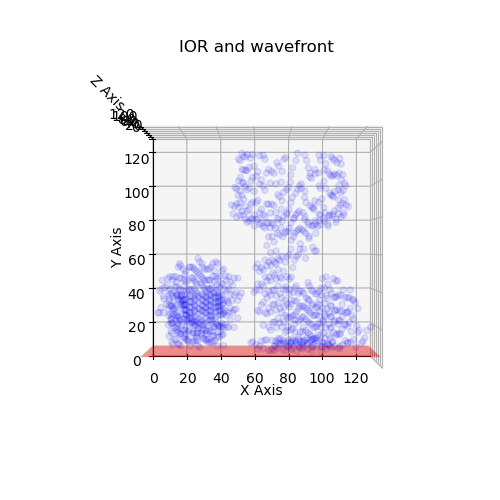

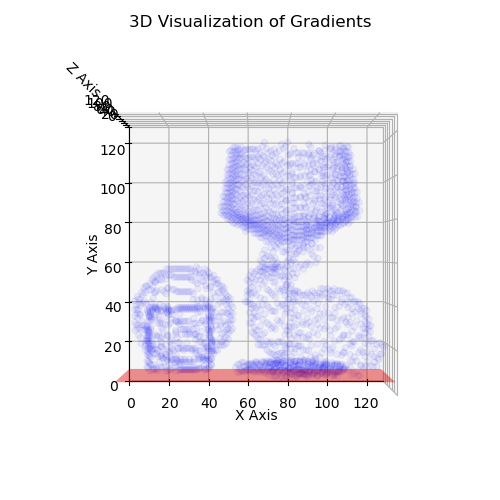

In [1]:
from setup.voxel_setup import setup_voxel_scene, NUM_XYZ
from common.plot import Plotter
from simulation.simulator import get_irrad_loc_dir, compute_ior_gradient
from simulation.simulate_utils import remove_under_floor

import taichi as ti
from scipy import ndimage

%load_ext autoreload
%autoreload 2
# May comment it because the compatibility of this extension is not good
%matplotlib widget 
import numpy as np
# debug=True to check boundary access
ti.init(arch=ti.gpu)

scene, floor_height = setup_voxel_scene()

sampler_multiplier = 6
to_load_save = False
plotter = Plotter(sampler_multiplier, floor_height)

GAUSSIAN_SIGMA = 2.0
GAUSSIAN_RADIUS = 2

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=GAUSSIAN_SIGMA, radius=GAUSSIAN_RADIUS)
scene.attenuation = ndimage.gaussian_filter(scene.attenuation, sigma=GAUSSIAN_SIGMA, radius=GAUSSIAN_RADIUS)
scene.scatter_strength = ndimage.gaussian_filter(scene.scatter_strength, sigma=GAUSSIAN_SIGMA, radius=GAUSSIAN_RADIUS)

scene.gradient = compute_ior_gradient(scene.ior)

In [14]:
import numpy as np
test_gradient = scene.gradient
print(test_gradient.shape)

non_zero_gradient = np.linalg.norm(test_gradient, axis=-1) > 0
print(np.sum(non_zero_gradient))

grad_mask = np.linalg.norm(test_gradient, axis=-1) >  4.0
print(grad_mask.shape)
print(np.sum(grad_mask))

(128, 128, 128, 3)
191005
(128, 128, 128)
0


## 2. Perform light simulation

In [ ]:
scene.irradiance, scene.local_diretion = get_irrad_loc_dir(scene, sampler_multiplier, 
                                                           to_load_save=to_load_save, 
                                                           plotter=plotter,
                                                           num_show_images=3)
scene.ior = remove_under_floor(scene.ior, floor_height)

In [ ]:
# plotter.plot_irradiance_grid(scene.irradiance)
plotter.plot_irradiance_slices(scene.irradiance, num_slices=4, z_start=30, z_end=100)
# plotter.plot_local_direction_grid_slices(scene.local_diretion[:, floor_height:, :], num_slices=4, z_start=30, z_end=100)

## 3. Ray marching render

In [ ]:
scene.display()

## 4. Different data structures to store or fit irradiance

In [ ]:
from data.siren import SirenFitter, siren_post_process
from data.mlp import MLP, mlp_post_process
from data.octree import Octree, octree_post_process

### 4.1 SIREN to fit irradiance

In [ ]:
siren_fitter= SirenFitter(scene.irradiance, floor_height, sampler_multiplier,
                     hidden_features=256, hidden_layers=3, omega=24)
siren_fitter.fit(total_epochs=24, batch_size=20000, lr=5e-4)

In [ ]:
siren_res = siren_fitter.infer()
plotter.plot_irradiance_slices(siren_res, threshold=3, num_slices=4, z_start=30, z_end=100)
siren_res.shape

In [ ]:
corrected_siren_res = siren_post_process(siren_res, gamma=0.2)
plotter.plot_irradiance_slices(corrected_siren_res, threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
assert corrected_siren_res.shape == scene.irradiance.shape, "The shape of the corrected siren result should be the same as the original irradiance grid"
scene.irradiance = corrected_siren_res
scene.display()

### 4.2 MLP to fit irradiance

In [ ]:
mlp = MLP(scene.irradiance, floor_height, NUM_XYZ, sampler_multiplier, num_epoches=150)

In [ ]:
# Visualize the predicted irradiance field
mlp_predicted_irradiance = mlp.predict(pad=True)
plotter.plot_irradiance_slices(mlp_predicted_irradiance, threshold=3, 
                               num_slices=4, z_start=30, z_end=100)

In [ ]:
corrected_mlp_res = mlp_post_process(mlp_predicted_irradiance, None)
plotter.plot_irradiance_slices(corrected_mlp_res, threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
assert corrected_mlp_res.shape == scene.irradiance.shape, "The shape of the corrected mlp result should be the same as the original irradiance grid"
scene.irradiance = corrected_mlp_res
scene.display()

### 4.3 Octree to store irradiance

In [ ]:
octree = Octree(threshold=14)
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter, num_slices=4, z_start=30, z_end=100)

In [ ]:
octree_res = octree.init_empty_grid()
octree.fill_grid(octree.root, octree_res, 0, 0, 0, octree.grid_size)
plotter.plot_irradiance_slices(octree_res, threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
corrected_octree_res = octree_post_process(octree_res)
plotter.plot_irradiance_slices(corrected_octree_res, threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
assert corrected_octree_res.shape == scene.irradiance.shape, "The shape of the corrected octree result should be the same as the original irradiance grid"
scene.irradiance = corrected_octree_res
scene.display()

In [ ]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value